In [2]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import *
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
%matplotlib inline

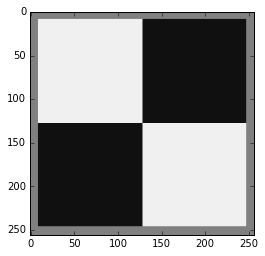

In [3]:
img = cv2.cvtColor(cv2.imread('input/ps1-input0.png'), cv2.COLOR_BGR2RGB)
plt.imshow(img)

True

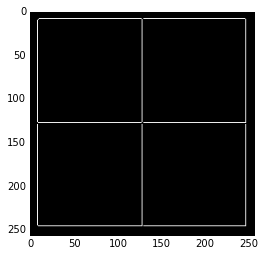

In [4]:
# Question 1.a
img_edges = cv2.Canny(img, 100, 200)
plt.imshow(img_edges, 'gray')
cv2.imwrite('output/ps1-1-a-1.png', img_edges)

True

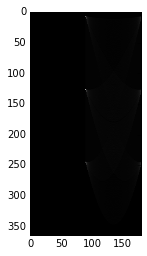

In [99]:
# Question 2.a -- Implement Hough transform
def hough_lines_acc(BW, theta_list=None, rho_res=None):
    """
    Returns (H, theta, rho)
    """
    if theta_list is None:
        theta_list = np.linspace(-89, 90, 180)
    if rho_res is None:
        rho_res = 1
    
    height, width, depth = img.shape
    max_rho = sqrt(height**2 + width**2)
    rho_list = np.array(range(0, ceil(max_rho)+1, rho_res))

    H = np.zeros((len(rho_list), len(theta_list)))
    
    edge_indices = np.nonzero(BW)
    for (row, col) in zip(*edge_indices):
        for theta_idx, theta in enumerate(theta_list):
            if theta >= 0:
                rho = col*cos(theta*pi/180) + row*sin(theta*pi/180)

                rho_idx = int(round(rho))
                H[rho_idx, theta_idx] += 1
    
    return (H, theta_list, rho_list)

H, theta, rho = hough_lines_acc(img_edges)
Hnorm = H/(np.amax(H)) * 255  # Normalize
plt.imshow(Hnorm, 'gray')

cv2.imwrite('output/ps1-2-a-1.png', Hnorm)

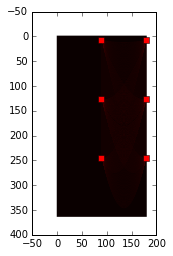

In [100]:
# Question 2.b
def hough_peaks(H, num_peaks = 10, nhood_size = None):
    """
    Find the top 'num_peaks' peaks in H
    
    Returns a num_peaks x 2 matrix with coordinates of peaks
    """
    if nhood_size is None:
        nhood_size = list(H.shape)
        nhood_size[0] = ceil(int(nhood_size[0]/50.)) // 2 * 2 + 1
        nhood_size[1] = ceil(int(nhood_size[1]/50.)) // 2 * 2 + 1
        
    nhood_filter = np.zeros(nhood_size)
        
    Hc = H.copy()
    peaks = np.empty((num_peaks, 2), dtype=np.uint32)
    last_max = np.inf
    for i in range(num_peaks):
        max_idx = np.argmax(Hc)
        r_idx, c_idx = np.unravel_index([max_idx], Hc.shape)
        peaks[i,:] = [r_idx, c_idx]        

        r_offset = -nhood_size[0]//2
        c_offset = -nhood_size[1]//2

        for k1, k2 in np.ndindex(nhood_filter.shape):
            x_idx, y_idx = (r_idx + r_offset + k1, c_idx + c_offset+k2)
            x_idx = min(max(0, x_idx), Hc.shape[0]-1)
            y_idx = min(max(0, y_idx), Hc.shape[1]-1)
            Hc[x_idx, y_idx] = 0

    return peaks

peaks = hough_peaks(H, 6, nhood_size=(51,51))
fig = plt.figure()
plt.imshow(Hnorm, 'hot')
plt.plot(peaks[:,1], peaks[:,0], 'rs')
fig.savefig('ps1-2-b-1.png')

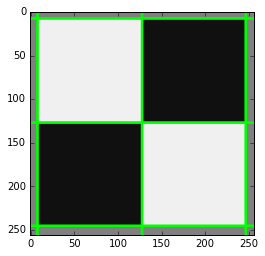

In [102]:
# Question 2.c
def hough_lines_draw(img, outfile, peaks, rho, theta, verbose=False):
    height, width, depth = img.shape
    img2 = img.copy()
    for rho_idx, theta_idx in peaks:
        s_theta = sin(theta[theta_idx]*pi/180.)
        c_theta = cos(theta[theta_idx]*pi/180.)
        
        c = rho[rho_idx]*s_theta   # Y intercept
        
        if abs(theta[theta_idx]) < 1:   # theta = 0 -> normal is along 'x', line is vertical
            pt1 = (0, floor(rho[rho_idx]))
            pt2 = (height, floor(rho[rho_idx]))
        else:

            m = c_theta/s_theta   # row and columns opposite of x and y
            pt1 = (floor(c), 0)
            pt2 = (floor(m*width+c), width)
#             if verbose:
#                 print('Theta : '+str(theta[theta_idx])+', ct = '+str(c_theta)+', st = '+str(s_theta)+', c = '+str(c))
                

                   
        cv2.line(img2, pt1, pt2, (0,255,0), 2)
        
        if verbose:
            print('Theta : '+str(theta[theta_idx])+', Rho : '+str(rho[rho_idx]))
            print((pt1, pt2))
    cv2.imwrite(outfile, img2)
    plt.imshow(img2)

hough_lines_draw(img, 'output/ps1-2-c-1.png', peaks, rho, theta)

True

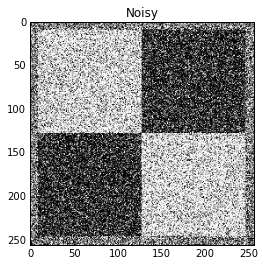

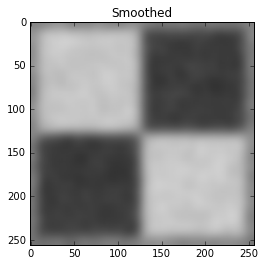

In [105]:
# Question 3.a
img_noisy = cv2.cvtColor(cv2.imread('input/ps1-input0-noise.png'), cv2.COLOR_BGR2RGB)
img_smoothed = cv2.GaussianBlur(img_noisy, (41,41), 0)
plt.figure()
plt.imshow(img_noisy)
plt.title('Noisy')
plt.figure()
plt.imshow(img_smoothed)
plt.title('Smoothed')
cv2.imwrite('output/ps1-3-a-1.png', img_smoothed)

True

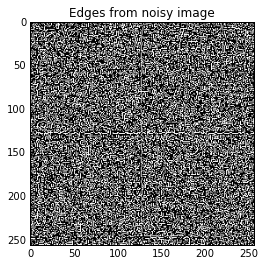

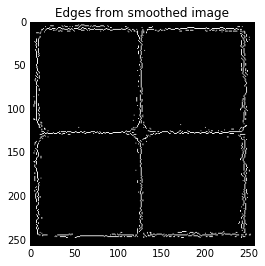

In [113]:
edges_noisy = cv2.Canny(img_noisy, 10, 50)
edges_smoothed = cv2.Canny(img_smoothed, 10, 32)
plt.figure()
plt.imshow(edges_noisy, 'gray')
plt.title('Edges from noisy image')
cv2.imwrite('output/ps1-3-b-1.png', edges_noisy)
plt.figure()
plt.imshow(edges_smoothed, 'gray')
plt.title('Edges from smoothed image')
cv2.imwrite('output/ps1-3-b-2.png', edges_smoothed)

[[  7  89]
 [244 179]
 [126  89]
 [244  89]
 [  8 179]
 [127 179]]


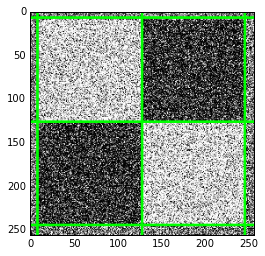

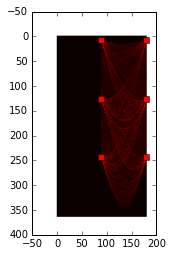

In [115]:
# Question 3
H, theta, rho = hough_lines_acc(edges_smoothed)
Hnorm = H/(np.amax(H)) * 255  # Normalize
peaks = hough_peaks(H, 6, nhood_size=(21,21))
print(peaks)
hough_lines_draw(img_noisy, 'output/ps1-3-c-2.png', peaks, rho, theta)

fig = plt.figure()
plt.imshow(Hnorm, 'hot')
plt.plot(peaks[:,1], peaks[:,0], 'rs')
fig.savefig('ps1-3-c-1.png')